# Race feature importance

Notebook to determine what features of a race have the biggest impact on the participants time

### Load Data

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
df = pd.read_csv("../data/data_cleaned.csv", low_memory=False)
df = df[df['Event Type']=='Distance']

In [3]:
df.columns

Index(['Runner ID', 'First Name', 'Surname', 'Nat.', 'Gender', 'Age',
       'Age Group', 'Cat', 'YOB', 'Race Count', 'Cumulative Distance KM',
       'Event ID', 'Event', 'Event Type', 'Date', 'Race Location',
       'Elevation Gain', 'Elevation Gain per KM', 'Total Finishers',
       'Male Finishers', 'Female Finishers', 'Time Seconds Winner',
       'Distance Winner', 'Rank', 'Rank M/F', 'Cat. Rank', 'Finish Percentage',
       'Performance Ratio', 'Distance/Time', 'Distance KM', 'Terrain',
       'Time Seconds Finish', 'Distance Finish', 'Average Speed',
       'Avg.Speed km/h'],
      dtype='object')

### Features

In [12]:
# 2. Feature Engineering
def engineer_features(df):
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['Terrain', 'Gender', 'Event Type'])
    
    return df

df_engineered = engineer_features(df)

# Select features for the model
features = ['Age', 'Distance KM', 'Elevation Gain', 'Elevation Gain per KM', 'Month', 
            'Total Finishers', 'Performance Ratio', 'Finish Percentage', 
            'Terrain_road', 'Terrain_trail', 'Terrain_track', 'Gender_M', 'Gender_F',
            'Event Type_Distance']

In [ ]:

X = df_engineered[features]
X_winner = df_engineered[df_engineered['Rank']==1]
X_winner = X_winner[features]

# Time data
y_average = df_engineered.groupby('Event ID')['Time Seconds Finish'].transform('mean')
y_median = df_engineered.groupby('Event ID')['Time Seconds Finish'].transform('median')

y_winner = X_winner['Time Seconds Finish']

# Speed data
y_average_speed = df_engineered.groupby('Event ID')['Average Speed'].transform('mean')
y_median_speed = df_engineered.groupby('Event ID')['Average Speed'].transform('median')

y_winner_speed = X_winner['Average Speed']

### Random Forest model

In [ ]:
# 3. Model Building
def build_and_evaluate_model(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print(f"\nFeature Importance for {model_name}:")
    print(feature_importance)
    
    return feature_importance

In [18]:
# Build models for fastest, average, and median times
fastest_importance = build_and_evaluate_model(X_winner, y_winner, "Fastest Time")
average_importance = build_and_evaluate_model(X, y_average, "Average Time")
median_importance = build_and_evaluate_model(X, y_median, "Median Time")


Feature Importance for Average Time:
                  feature  importance
1             Distance KM    0.871675
2          Elevation Gain    0.033818
3   Elevation Gain per KM    0.030639
5         Total Finishers    0.022575
6       Performance Ratio    0.014393
4                   Month    0.012481
9           Terrain_trail    0.009122
8            Terrain_road    0.001920
7       Finish Percentage    0.001636
0                     Age    0.001511
10          Terrain_track    0.000100
12               Gender_F    0.000066
11               Gender_M    0.000065
13    Event Type_Distance    0.000000


KeyboardInterrupt: 

In [ ]:
fastest_importance_speed = build_and_evaluate_model(X_winner, y_winner_speed, "Fastest Speed")
average_importance_speed = build_and_evaluate_model(X_winner, y_average_speed, "Average Speed")
median_importance_speed = build_and_evaluate_model(X_winner, y_median_speed, "Median Speed")

### Plots

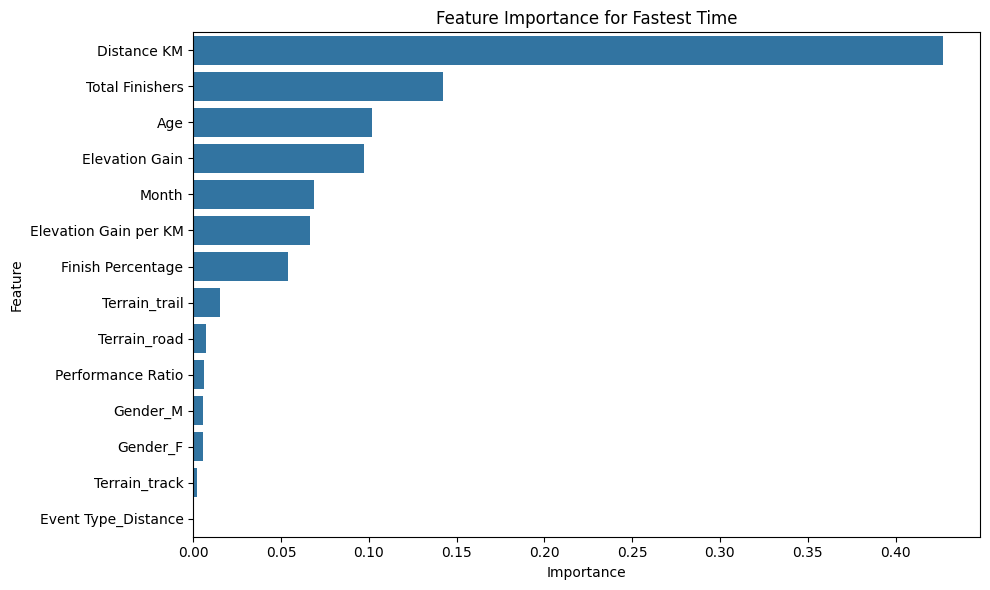

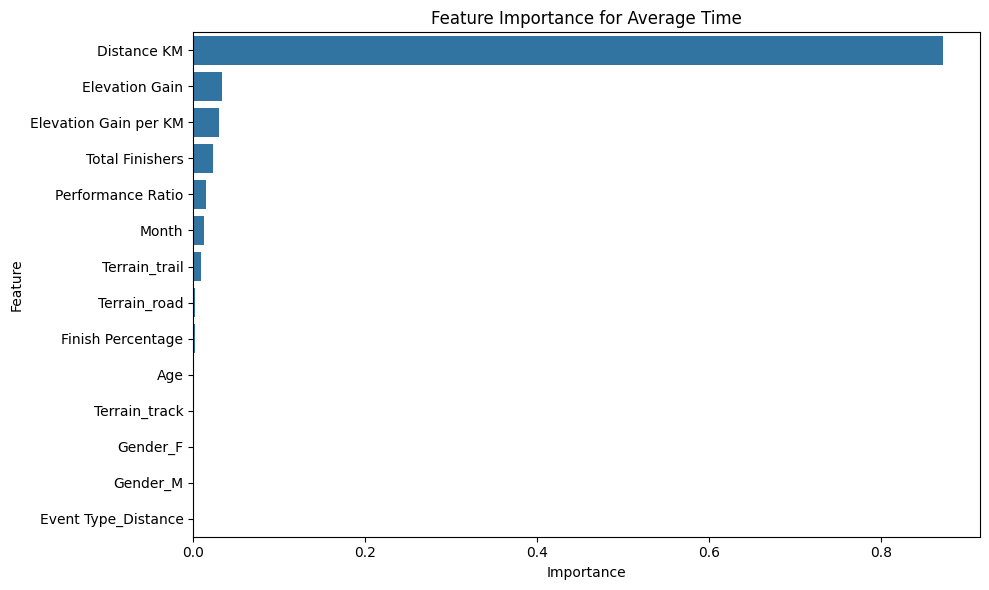

<Figure size 1200x800 with 0 Axes>

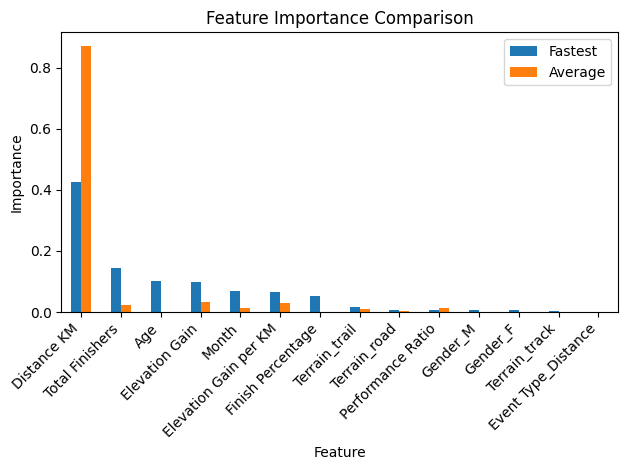


Overall Feature Importance:
                  feature  overall_importance
0             Distance KM            0.649226
1         Total Finishers            0.082533
3          Elevation Gain            0.065641
2                     Age            0.051588
5   Elevation Gain per KM            0.048589
4                   Month            0.040748
6       Finish Percentage            0.027713
7           Terrain_trail            0.012229
9       Performance Ratio            0.010283
8            Terrain_road            0.004594
10               Gender_M            0.002833
11               Gender_F            0.002753
12          Terrain_track            0.001269
13    Event Type_Distance            0.000000


In [19]:
# 4. & 5. Feature Importance Analysis and Visualization
def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title(f"Feature Importance for {title}")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance(fastest_importance, "Fastest Time")
plot_feature_importance(average_importance, "Average Time")
plot_feature_importance(median_importance, "Median Time")

# Compare feature importances across models
all_importances = pd.merge(fastest_importance, average_importance, on='feature', suffixes=('_fastest', '_average'))
all_importances = pd.merge(all_importances, median_importance, on='feature', suffixes=('', '_median'))
all_importances.columns = ['feature', 'importance_fastest', 'importance_average', 'importance_median']

plt.figure(figsize=(12, 8))
all_importances.set_index('feature').plot(kind='bar')
plt.title("Feature Importance Comparison")
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend(['Fastest', 'Average', 'Median'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate and print overall importance
all_importances['overall_importance'] = all_importances[['importance_fastest', 'importance_average', 'importance_median']].mean(axis=1)
overall_importance = all_importances.sort_values('overall_importance', ascending=False)
print("\nOverall Feature Importance:")
print(overall_importance[['feature', 'overall_importance']])

In [ ]:
plot_feature_importance(fastest_importance_speed, "Fastest Time")
plot_feature_importance(average_importance_speed, "Average Time")
plot_feature_importance(median_importance_speed, "Median Time")

# Compare feature importances across models
all_importances = pd.merge(fastest_importance, average_importance, on='feature', suffixes=('_fastest', '_average'))
all_importances = pd.merge(all_importances, median_importance, on='feature', suffixes=('', '_median'))
all_importances.columns = ['feature', 'importance_fastest', 'importance_average', 'importance_median']

plt.figure(figsize=(12, 8))
all_importances.set_index('feature').plot(kind='bar')
plt.title("Feature Importance Comparison")
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend(['Fastest', 'Average', 'Median'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate and print overall importance
all_importances['overall_importance'] = all_importances[['importance_fastest', 'importance_average', 'importance_median']].mean(axis=1)
overall_importance = all_importances.sort_values('overall_importance', ascending=False)
print("\nOverall Feature Importance:")
print(overall_importance[['feature', 'overall_importance']])